In [27]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW, lr_scheduler as LRScheduler

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weightless,
    train_weightless,
    EarlyStopper,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [28]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric_key = "weighted_median"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [29]:
start_year = 2006
eval_start_year = 2021 # eval_years = [2021, 2022]

dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}"]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= 2021]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [30]:
eval_df

,unit_price_wmedian_pct_chg,unit_price_wmedian,year,count,total_traded_area,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,new_dwellings,existing_dwellings,net_migration_ratio,new_dwellings_ratio,area_code,normalized_unit_price_wmedian_pct_chg
18420,-0.085792,19499.828415,2021,17.0,5360.0,17517.0,8458.0,24323664.0,2875.817451,0.004501,0.007827,0.0,7150.0,0.000057,0.000000,21521,-0.326127
18421,0.262520,145601.485729,2021,60.0,14475.0,44682.0,17403.0,44828280.0,2575.893811,0.068996,0.035703,415.0,18598.0,0.014301,0.022314,47215,0.101407
18422,0.165134,74714.285714,2021,148.0,48770.0,141483.0,69902.0,223732116.0,3200.654001,0.021036,0.017399,718.0,61346.0,0.000997,0.011704,22214,-0.018129
18423,1.165136,8954.575163,2021,3.0,1220.0,10347.0,4524.0,11471191.0,2535.630195,0.033343,0.030831,0.0,0.0,0.002320,0.000000,31389,1.209317
18424,-0.210202,21094.594595,2021,27.0,22020.0,5171.0,2711.0,8769950.0,3234.950203,0.010219,0.019162,0.0,0.0,-0.001547,0.000000,19425,-0.478833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19862,-0.447846,12240.384615,2021,54.0,21445.0,62780.0,31183.0,92257359.0,2958.578681,0.052622,0.073382,236.0,31631.0,-0.007009,0.007461,17206,-0.770527
19863,1.063325,19519.168291,2021,4.0,1460.0,9694.0,3622.0,9658039.0,2666.493374,0.051138,0.043302,0.0,0.0,0.001238,0.000000,38488,1.084349
19864,-0.096505,3770.491803,2021,1.0,610.0,4525.0,1825.0,4737424.0,2595.848767,0.036568,0.034296,0.0,0.0,-0.001105,0.000000,33663,-0.339276
19865,0.144219,27800.751880,2021,32.0,15630.0,20282.0,8670.0,22540659.0,2599.845329,0.023988,0.034853,0.0,16920.0,0.000986,0.000000,30401,-0.043802


In [31]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

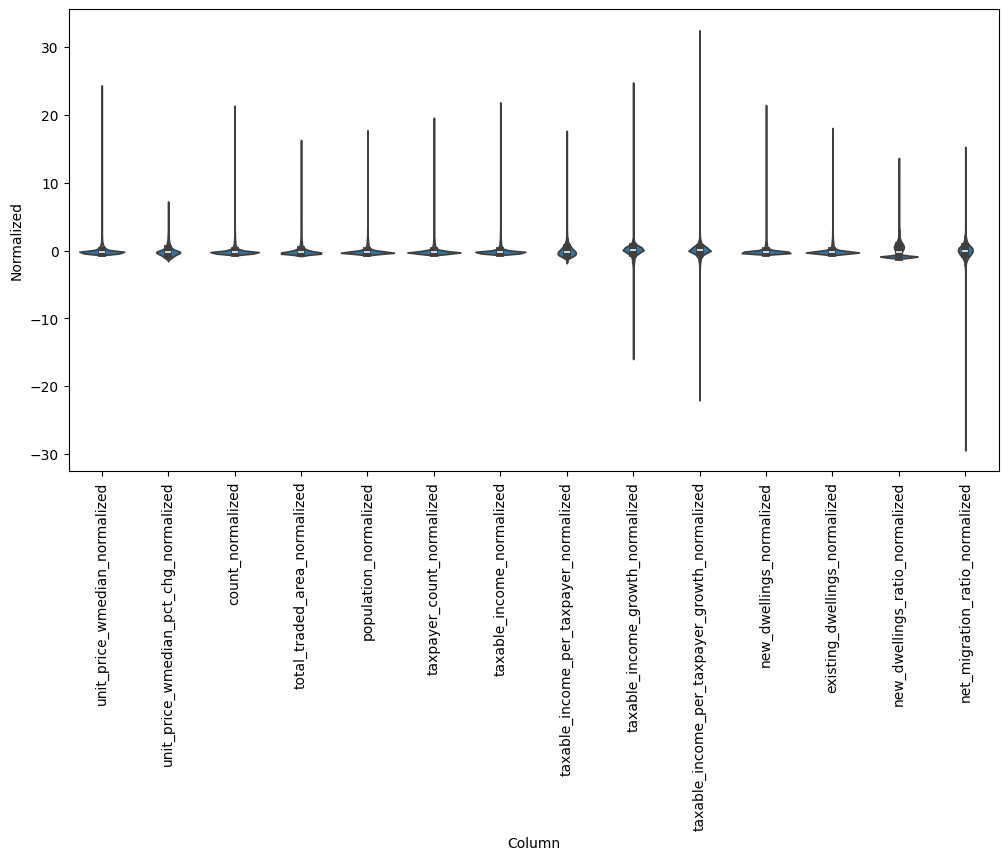

In [32]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [33]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# To account for years where the data is not available and all the values are zero. In those situations, the normalized values will be NaN.
df = df.fillna(0)

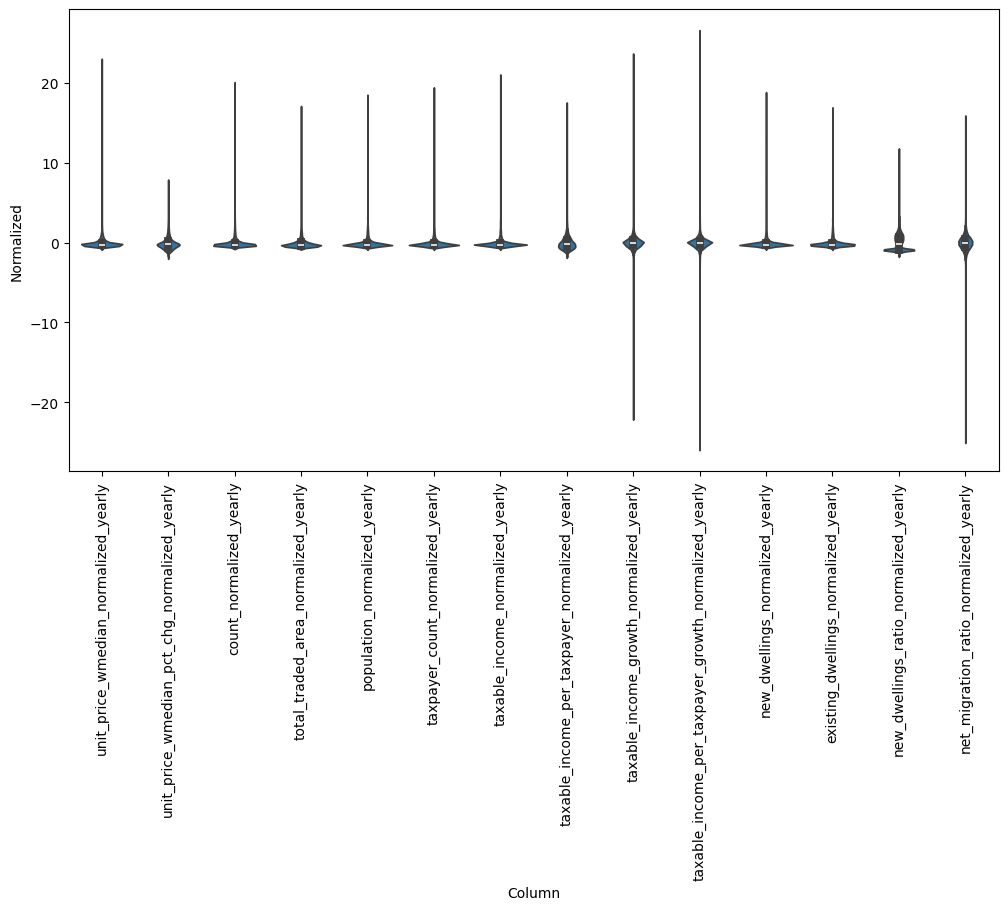

In [34]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [35]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 15) (1,) [-0.25926034] [1.0447453]
1 (0, 15) (1,) [-0.05850584] [2.28315741]
2 (0, 15) (1,) [0.3541434] [1.12597522]
3 (0, 15) (1,) [-0.3474138] [1.0192749]
0 torch.Size([5, 15]) torch.Size([1]) tensor([-0.2593]) tensor([1.0447])
1 torch.Size([5, 15]) torch.Size([1]) tensor([-0.0585]) tensor([2.2832])
2 torch.Size([5, 15]) torch.Size([1]) tensor([0.3541]) tensor([1.1260])
3 torch.Size([5, 15]) torch.Size([1]) tensor([-0.3474]) tensor([1.0193])


In [36]:
BATCH_SIZE = 256

In [37]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19867 entries, 0 to 19866
Data columns (total 46 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   unit_price_wmedian_pct_chg                            19867 non-null  float64
 1   unit_price_wmedian                                    19867 non-null  float64
 2   year                                                  19867 non-null  int64  
 3   count                                                 19867 non-null  float64
 4   total_traded_area                                     19867 non-null  float64
 5   population                                            19867 non-null  float64
 6   taxpayer_count                                        19867 non-null  float64
 7   taxable_income                                        19867 non-null  float64
 8   taxable_income_per_taxpayer                           19

### Building the Transformer Model

In [39]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [40]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [41]:
%%timeit

model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.3910490274429321
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256,

In [42]:
# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping and regularization so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary

def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

# loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
# model.load_state_dict(loaded_state_dict, strict=False)


In [43]:
learning_rate = 1e-5 # 3e-4
weight_decay = 1 # 1
num_epochs = 200

In [44]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = LRScheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [45]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 3.9061, Eval Loss: 3.8009
Train R^2: 0.0332, Eval R^2: 0.0612
Epoch: 1
Train Loss: 3.7941, Eval Loss: 3.6901
Train R^2: 0.0604, Eval R^2: 0.0877
Epoch: 2
Train Loss: 3.7015, Eval Loss: 3.5417
Train R^2: 0.0833, Eval R^2: 0.1234
Epoch: 3
Train Loss: 3.6118, Eval Loss: 3.4456
Train R^2: 0.1056, Eval R^2: 0.1461
Epoch: 4
Train Loss: 3.5545, Eval Loss: 3.4129
Train R^2: 0.1199, Eval R^2: 0.1539
Epoch: 5
Train Loss: 3.5154, Eval Loss: 3.3979
Train R^2: 0.1295, Eval R^2: 0.1576
Epoch: 6
Train Loss: 3.4899, Eval Loss: 3.3883
Train R^2: 0.1358, Eval R^2: 0.1601
Epoch: 7
Train Loss: 3.4711, Eval Loss: 3.3815
Train R^2: 0.1404, Eval R^2: 0.1619
Epoch: 8
Train Loss: 3.4566, Eval Loss: 3.3758
Train R^2: 0.1440, Eval R^2: 0.1634
Epoch: 9
Train Loss: 3.4439, Eval Loss: 3.3709
Train R^2: 0.1471, Eval R^2: 0.1648
Epoch: 10
Train Loss: 3.4333, Eval Loss: 3.3658
Train R^2: 0.1497, Eval R^2: 0.1661
Epoch: 11
Train Loss: 3.4242, Eval Loss: 3.3610
Train R^2: 0.1519, Eval R^2: 0.1674
Ep

KeyboardInterrupt: 

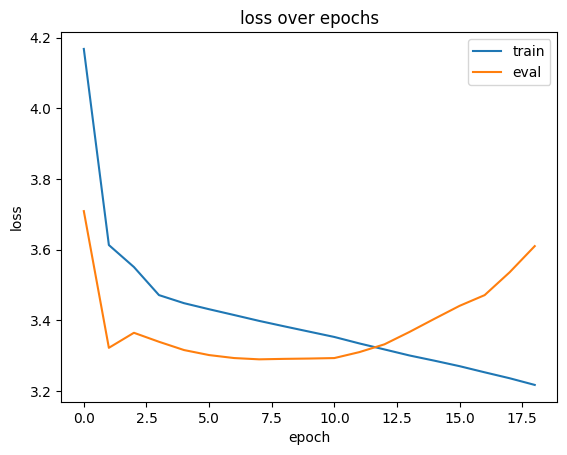

In [21]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

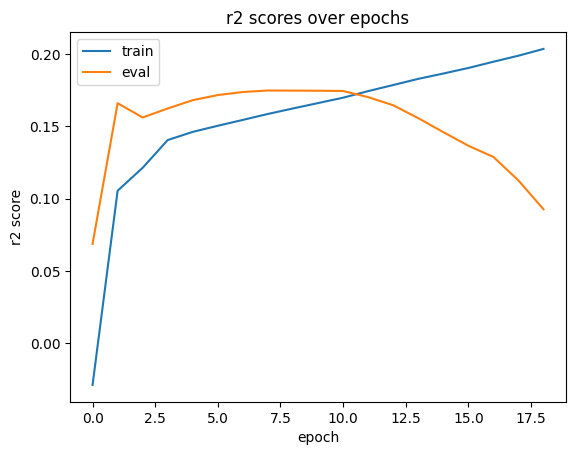

In [22]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [32]:
# untrained model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4521
Eval R2: 0.1688


### Pretraining and transfer gameplan

Within my time series model, I have the Transformer Encoder and the Positional Encoder. 
Once the model is done training, I will take the weights and save it to a file.
Then, I will load up the new model with this file.



In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

### The High Variance Problem

The model is overfitting right now